In [1]:
# !pip install --ignore-installed --upgrade tensorflow

In [2]:
# !pip show tensorflow

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [4]:
from pathlib import Path

data_dir = Path("./superData")
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

135


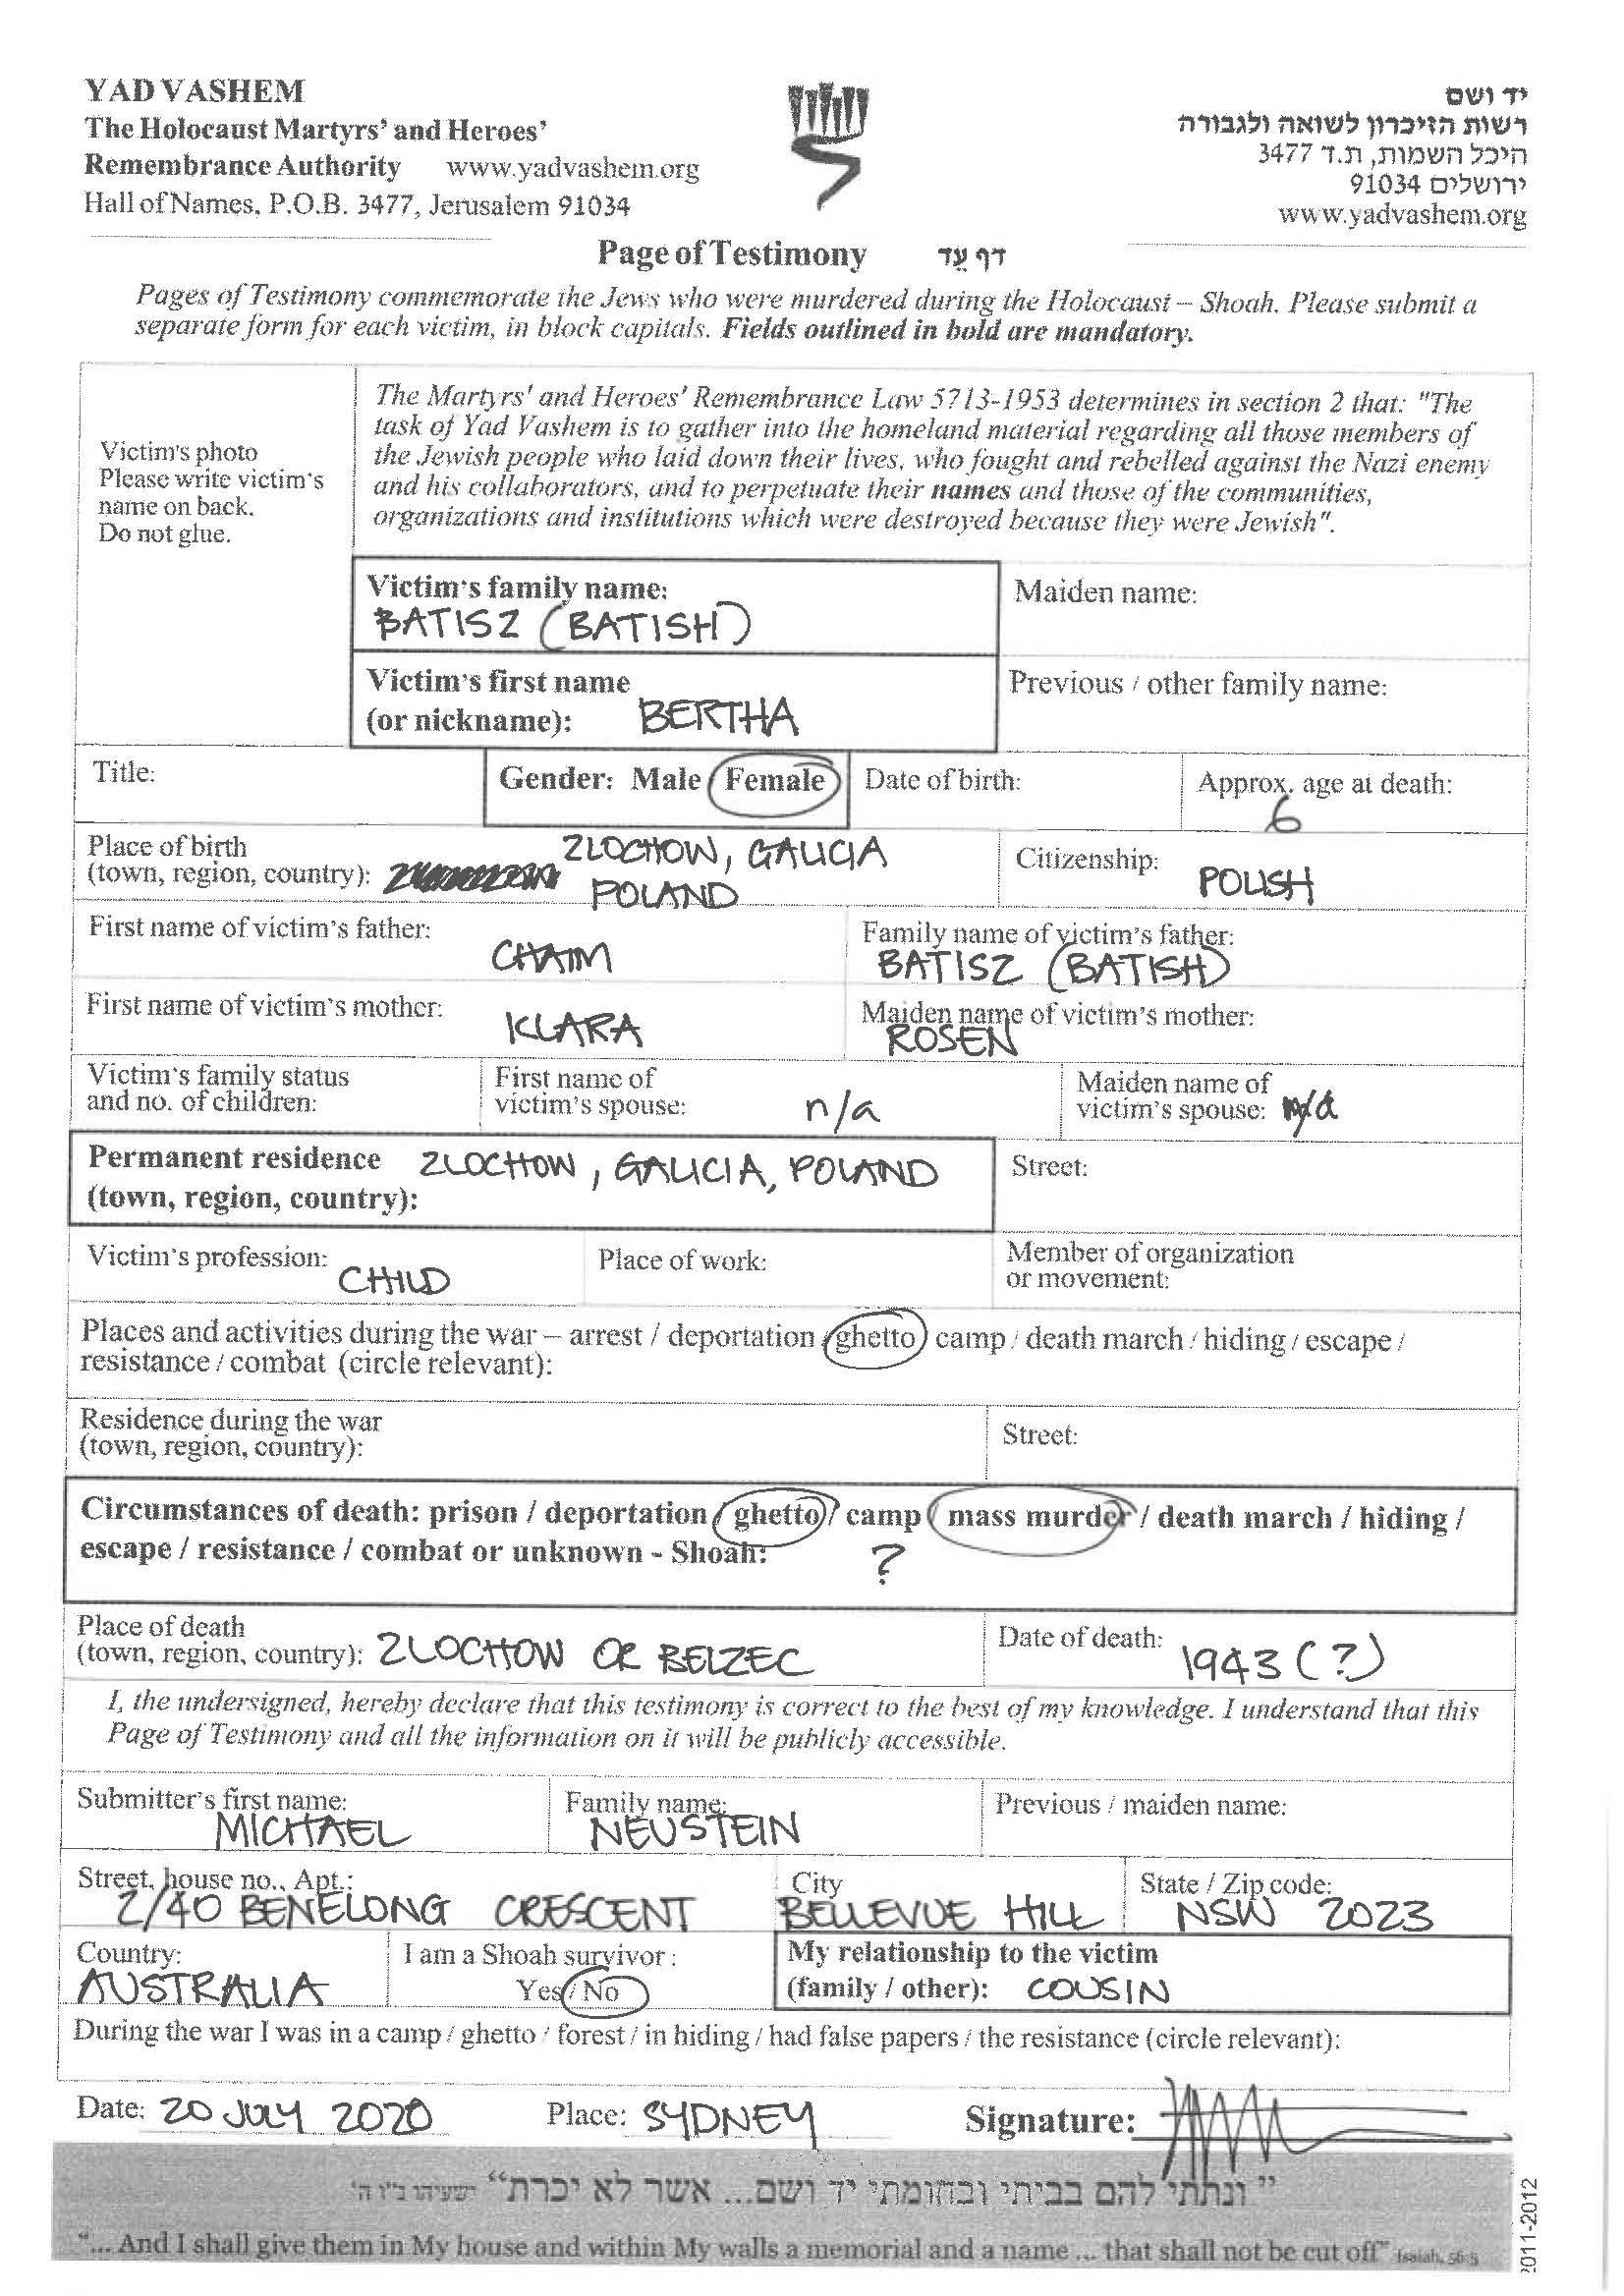

In [6]:
ed = list(data_dir.glob('0/*'))
PIL.Image.open(str(ed[0]))

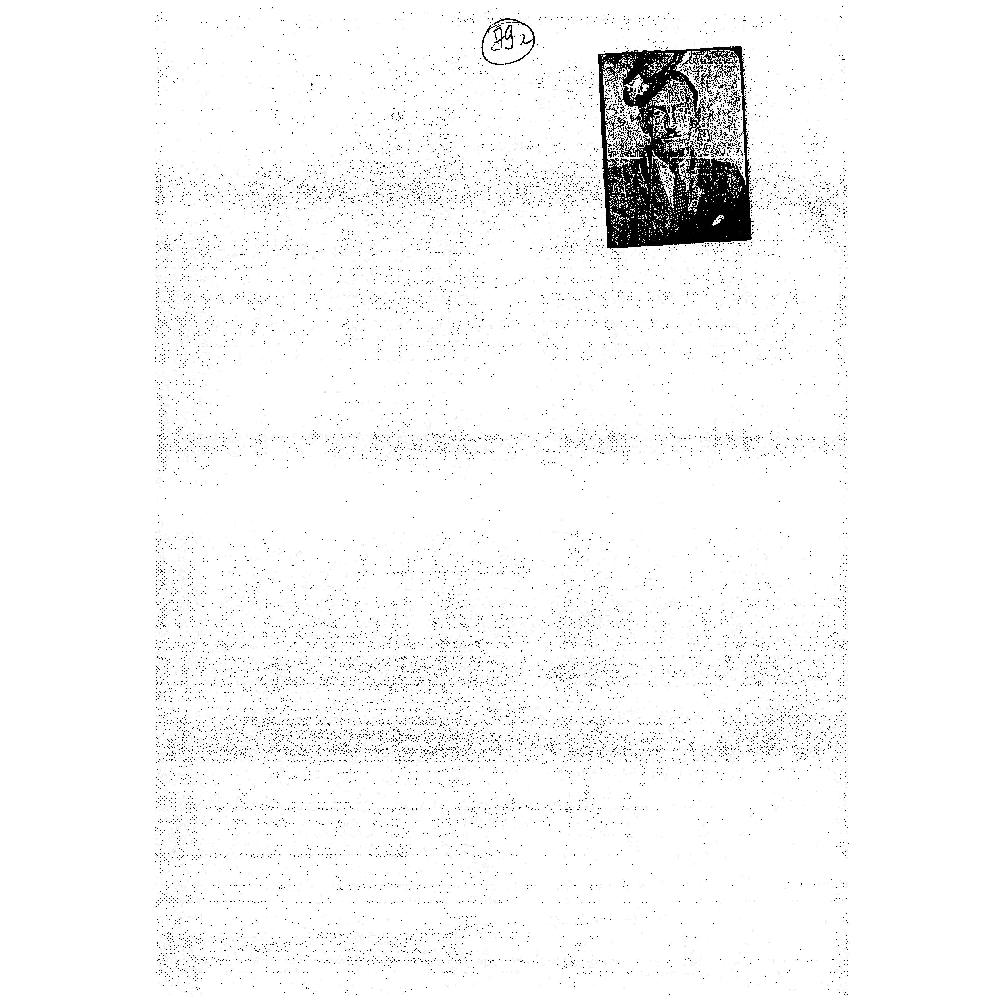

In [7]:
edp = list(data_dir.glob('1/*'))
PIL.Image.open(str(edp[0]))

In [8]:
batch_size = 32
img_height = 180
img_width = 180

In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 135 files belonging to 2 classes.
Using 108 files for training.


In [10]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 135 files belonging to 2 classes.
Using 27 files for validation.


In [11]:
class_names = train_ds.class_names
print(class_names)

['0', '1']


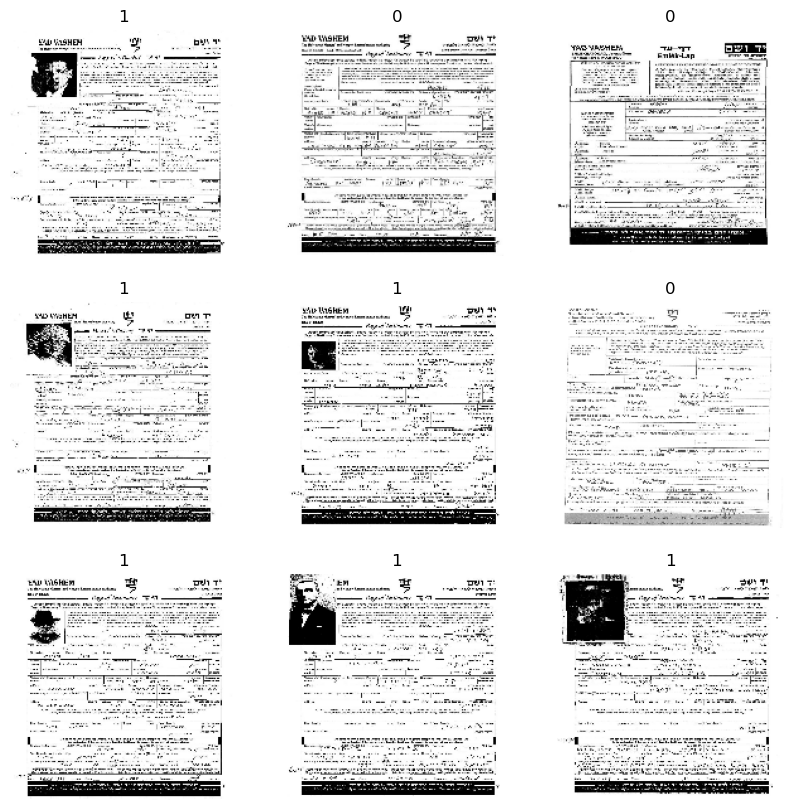

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [13]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
normalization_layer = layers.Rescaling(1./255)

In [16]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.24166133 1.0


In [17]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

C:\Users\326035854\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [18]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,988,898 (15.22 MB)

 Trainable params: 3,988,898 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step - accuracy: 0.6571 - loss: 1.4990 - val_accuracy: 0.1481 - val_loss: 1.2035
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.3704 - loss: 0.8236 - val_accuracy: 0.8519 - val_loss: 0.3291
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.6705 - loss: 0.4726 - val_accuracy: 0.8889 - val_loss: 0.2133
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.8164 - loss: 0.2644 - val_accuracy: 1.0000 - val_loss: 0.1439
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.9843 - loss: 0.1187 - val_accuracy: 1.0000 - val_loss: 0.0785
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9843 - loss: 0.0496 - val_accuracy: 1.0000 - val_loss: 0.0053
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.9829 - loss: 0.0386 - val_accuracy: 1.0000 - val_loss: 0.0069
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.9911 - loss: 0.0102 - val_accuracy: 1.0000 - val_loss:

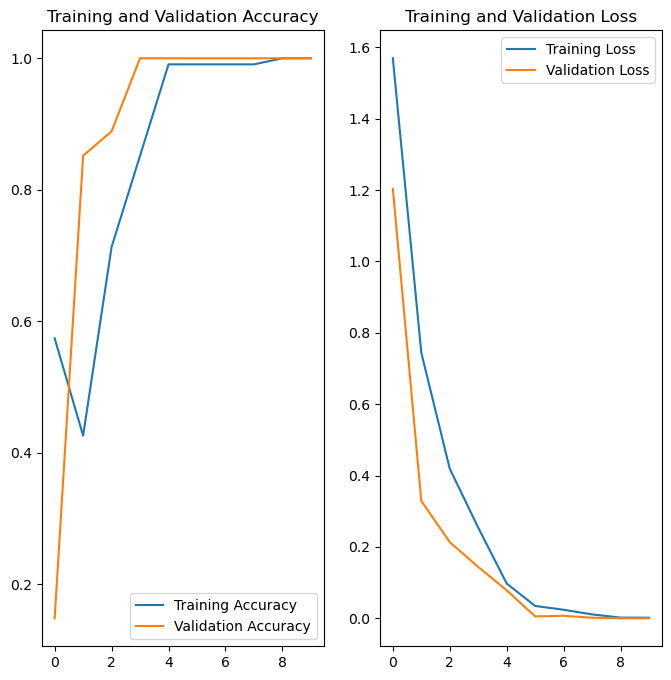

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [26]:
import os

# Define the directory path where the image 'pic' is located
image_directory = "./"

# Load the image 'pic' from the specified directory
pic_path = os.path.join(image_directory, '2222.jpg')

img = tf.keras.utils.load_img(pic_path, target_size=(img_height, img_width))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
This image most likely belongs to 1 with a 100.00 percent confidence.


In [27]:
model.save("ed.h5")